In [462]:
%reset

In [463]:
import cv2
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm

<h3>Keyframe</h3>
A keyframe is a frame where a change occurs in the timeline<br><br>
<img src="kf_exp.png" width=500>

In [ ]:

cap = cv2.VideoCapture('mudhalnee_mudivumnee.mp4')
# print(cap.get(cv2.CAP_PROP_FPS))

timestamps = []
frames=[]
key_frames=[]
temp_frame=0

while(cap.isOpened()):
    frame_exists, curr_frame = cap.read() #curr_frame consist of matrix representation of image
    if frame_exists==True:
        sec=cap.get(cv2.CAP_PROP_POS_MSEC)/1000
        timestamps.append(sec)
        cv2.imwrite(f"frames/{sec}.jpg",curr_frame)
        frames.append(curr_frame)
    else:
        break

cap.release()
# print(timestamps)


# approach 1

In [ ]:
cap = cv2.VideoCapture('mudhalnee_mudivumnee.mp4')
# print(cap.get(cv2.CAP_PROP_FPS))
prev_frame=cv2.imread("cycle.jpg") 
key_frames=[]

while(cap.isOpened()):
    frame_exists, curr_frame = cap.read() #curr_frame consist of matrix representation of image
    if frame_exists==True:
        timestamp=cap.get(cv2.CAP_PROP_POS_MSEC)/1000
        
        curr_hist = cv2.calcHist([curr_frame], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
        prev_hist = cv2.calcHist([prev_frame], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])

        curr_hist = cv2.normalize(curr_hist,curr_hist).flatten()
        prev_hist = cv2.normalize(prev_hist,prev_frame).flatten()

        comp=cv2.compareHist(curr_hist , prev_hist ,cv2.HISTCMP_BHATTACHARYYA) #corelation
        # print(comp)
    
        if comp>0.70:
            print("caught a keyframe")
            key_frames.append((prev_frame,curr_frame,timestamp))
        prev_frame=curr_frame

    else:
        break

cap.release()
# print(timestamps)

In [ ]:
print(len(key_frames))

In [ ]:
plt.subplot(1,2,1)
plt.imshow(key_frames[1][0])
plt.subplot(1,2,2)
plt.imshow(key_frames[1][1])
plt.show()

print("timestamp of this keyframe",key_frames[1][2])

In [ ]:
plt.subplot(1,2,1)
plt.imshow(key_frames[2][0])
plt.subplot(1,2,2)
plt.imshow(key_frames[2][1])
plt.show()

print("timestamp of this keyframe",key_frames[2][2])

# Yolo

In [518]:
names=[]
with open("coco.names","r") as doc:
    for name in doc.readlines():
        names.append(name.split(",")[0][1:-1])

In [519]:
len(names)

80

#### lets take 
#### YOLOv3-608	COCO trainval	test-dev	57.9	140.69 Bn	20	cfg	weights

In [425]:
modelConfiguration="yolov3.cfg"
modelweights="yolov3.weights"
net=cv2.dnn.readNetFromDarknet(modelConfiguration,modelweights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [516]:
#NETWORK ONLY ACCEPTS THE BLOB FORMAT

frame1=cv2.imread("frame2.jpg")
blob=cv2.dnn.blobFromImage(frame1,1/255,(wh,wh),[0,0,0],1,crop=False)

net.setInput(blob)
layernames=net.getLayerNames()
# print(layernames)
print(net.getUnconnectedOutLayers())
output_names=[layernames[199],layernames[226],layernames[253]]
print(output_names) #name of the output layers
outputs=net.forward(output_names)
print(len(outputs),type(outputs)) 
print(type(outputs[0]),type(outputs[1]),type(outputs[2]))
print(outputs[0].shape,outputs[1].shape,outputs[2].shape)
# wh=608
# frame1=cv2.imread("frame2.jpg")
# frame_re=cv2.resize(frame1,(wh,wh))
# plt.imshow(frame_re)
# plt.show()



[200 227 254]
['yolo_82', 'yolo_94', 'yolo_106']
3 <class 'tuple'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1083, 85) (4332, 85) (17328, 85)


#### Explanation about the outputs
(1083,85) <br>
1083 boxes detected <br>
85 refers 80 classes are prob prediction of each of the class rest 5 are cx,cy,w,h,confidence representing the presence of the object<br>
cx-x coordinate of the center<br>
cy-y coordinate of the center<br>
w-width of the box<br>
h-height of the bounding box

<img src="yolo_output_explanation.jpg">

In [429]:
print(len(outputs[0][0]) )#len should be 85

85


[(226, 59, 410, 433), (172, 79, 434, 450), (248, 84, 346, 440), (232, 75, 404, 461), (536, 85, 306, 442), (167, 109, 438, 427), (251, 117, 349, 409), (226, 105, 425, 437), (245, 92, 491, 456), (504, 93, 312, 462), (469, 103, 365, 440), (537, 88, 300, 473), (501, 98, 384, 454)]
indices [7 9]
(226, 105, 425, 437)


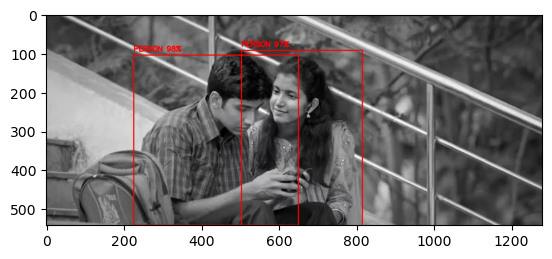

(504, 93, 312, 462)


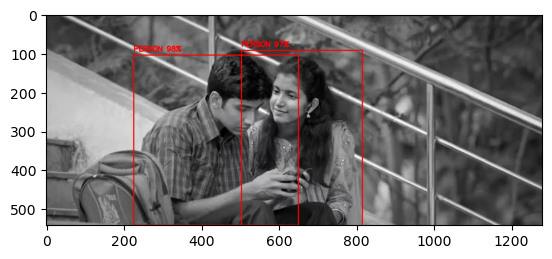

In [522]:
nms_thres=0.7
def find_objects(ouputs,image):
    ht,wd,channels=image.shape
    bbox =[]
    class_ids=[]
    confidence=[]
    for output in outputs:  
        for det in output:
            #lets take all prob of each class and find max
            scores=det[5:] #the first 5 are bbox informations as explained above
            class_id = np.argmax(scores,axis=0) #returns index of max elements geek.argmax(array, axis=0)
            confs = scores[class_id] #taking confidence of that prediction
            if confs>thres_conf:
                w,h= int(det[2]*wd),int(det[3]*ht)
                x,y= int ( ( det[0]*wd ) - w/2 ) , int( ( det[1]*ht )- h/2)
                bbox.append((x,y,w,h))
                class_ids.append(class_id)
                confidence.append(float(confs))
    print(bbox)
    indices=cv2.dnn.NMSBoxes(bbox,confidence,thres_conf,nms_thres) #returns how many objects detected 
    print("indices",indices)
    for i in indices:
        box=bbox[i]
        print(box)
        x,y,w,h=box[0],box[1],box[2],box[3]
        temp=cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        cv2.putText(image,f'{names[class_ids[i]].upper()} {int(confidence[i]*100)}%',(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2)
        plt.imshow(temp)
        plt.show()
       
find_objects(outputs,frame1)
              

# Merging
Warning : execution of this cell takes almost an hour

In [ ]:
import cv2
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm

In [ ]:
names=[]
with open("coco.names","r") as doc:
    for name in doc.readlines():
        names.append(name.split(",")[0][1:-1])

In [464]:
cap = cv2.VideoCapture('mudhalnee_mudivumnee.mp4')
# print(cap.get(cv2.CAP_PROP_FPS))
prev_frame=cv2.imread("cycle.jpg") #taking some random image for fisrt comparision
key_frames=[]
wh=608 #yolo prefered size
modelConfiguration="yolov3.cfg"
modelweights="yolov3.weights"
net=cv2.dnn.readNetFromDarknet(modelConfiguration,modelweights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
thres_conf=0.5
nms_thres=0.7 #lower means higher no os boxes


det_obj=[]

def find_objects(ouputs,image):
    ht,wd,channels=image.shape
    bbox =[]
    class_ids=[]
    confidence=[]
    for output in outputs:  
        for det in output:
            #lets take all prob of each class and find max
            scores=det[5:] #the first 5 are bbox informations as explained above
            class_id = np.argmax(scores,axis=0) #returns index of max elements geek.argmax(array, axis=0)
            confs = scores[class_id] #taking confidence of that prediction
            if confs>thres_conf:
                w,h= int(det[2]*wd),int(det[3]*ht)
                x,y= int ( ( det[0]*wd ) - w/2 ) , int( ( det[1]*ht )- h/2)
                bbox.append((x,y,w,h))
                class_ids.append(class_id)
                confidence.append(float(confs))
    print(bbox)
    indices=cv2.dnn.NMSBoxes(bbox,confidence,thres_conf,nms_thres) #returns how many objects detected 
    print("indices",indices)
    fin_ret=[]
    for i in indices:
        box=bbox[i]
        class_name=names[class_ids[i]]
        confi=int(confidence[i]*100)
        fin_ret.append((box,class_name,confi))
    return fin_ret
       

              
while(cap.isOpened()):
    frame_exists, curr_frame = cap.read() #curr_frame consist of matrix representation of image
    if frame_exists==True:
        timestamp=cap.get(cv2.CAP_PROP_POS_MSEC)/1000
        
        curr_hist = cv2.calcHist([curr_frame], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
        prev_hist = cv2.calcHist([prev_frame], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])

        curr_hist = cv2.normalize(curr_hist,curr_hist).flatten()
        prev_hist = cv2.normalize(prev_hist,prev_frame).flatten()

        comp=cv2.compareHist(curr_hist , prev_hist ,cv2.HISTCMP_BHATTACHARYYA) #corelation
        # print(comp)
    
        if comp>0.70:
            print("caught a keyframe")
            key_frames.append((prev_frame,curr_frame,timestamp))
        prev_frame=curr_frame

        ######## object detection ###########
        blob=cv2.dnn.blobFromImage(curr_frame,1/255,(wh,wh),[0,0,0],1,crop=False)
        net.setInput(blob)
        layernames=net.getLayerNames()
        output_names=[layernames[199],layernames[226],layernames[253]]
        outputs=net.forward(output_names)

        detected_obj=find_objects(outputs,curr_frame)
        det_obj.append((curr_frame,(detected_obj),timestamp))
    else:
        break

cap.release()
# print(timestamps)

caught a keyframe
caught a keyframe
caught a keyframe


3


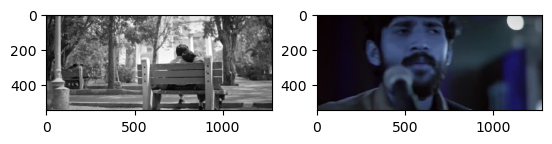

timestamp of this keyframe 14.958333333333332


In [465]:
print(len(key_frames))
plt.subplot(1,2,1)
plt.imshow(key_frames[1][0])
plt.subplot(1,2,2)
plt.imshow(key_frames[1][1])
plt.show()
print("timestamp of this keyframe",key_frames[1][2])

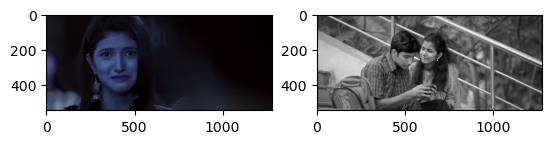

timestamp of this keyframe 60.666666666666664


In [466]:
plt.subplot(1,2,1)
plt.imshow(key_frames[2][0])
plt.subplot(1,2,2)
plt.imshow(key_frames[2][1])
plt.show()

print("timestamp of this keyframe",key_frames[2][2])

In [472]:
len(det_obj[0]) #len is 3 curr_frame,boundingbox,timestamp

3

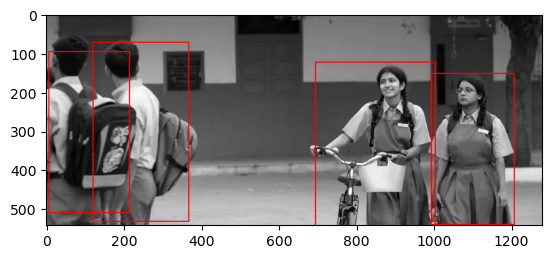

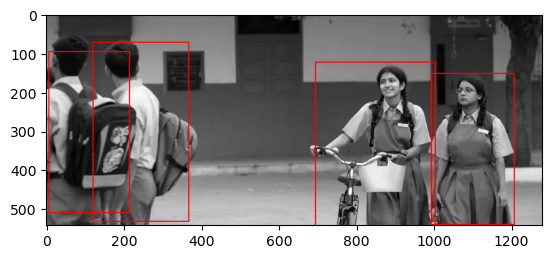

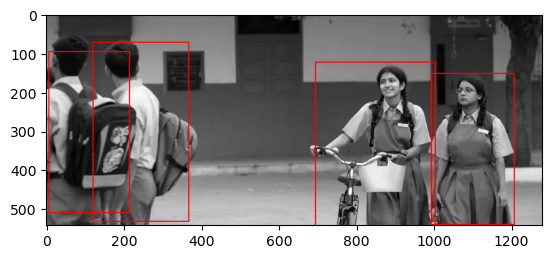

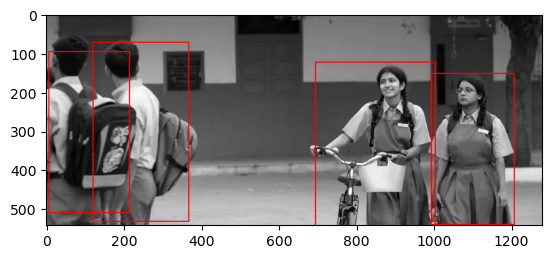

0.0

In [495]:
# Testing 
det_obj[0][1]
for i in det_obj[0][1]:
    box=i
    x,y,w,h=box[0],box[1],box[2],box[3]
    temp=cv2.rectangle(det_obj[0][0],(x,y),(x+w,y+h),(255,0,0),2)
    plt.imshow(temp)
    plt.show()
# cv2.rectangle(det_obj[0][0],)
det_obj[0][2]



In [511]:
#finding frame with more boxes:
count=0
maxed_out=[0]
for out in det_obj:
    # print(len(out[1]))
    if len(out[1])>count:
        maxed_out[0]=out
        count=len(out[1])


In [514]:
print(len(maxed_out))
maxed_out[0][1]

1


[(267, 54, 437, 499),
 (49, -28, 408, 599),
 (1098, 174, 69, 232),
 (1066, 11, 200, 567),
 (839, 8, 276, 528),
 (628, 49, 293, 500),
 (601, -3, 213, 253),
 (-5, -41, 185, 622)]

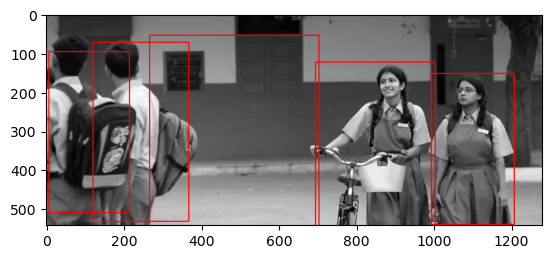

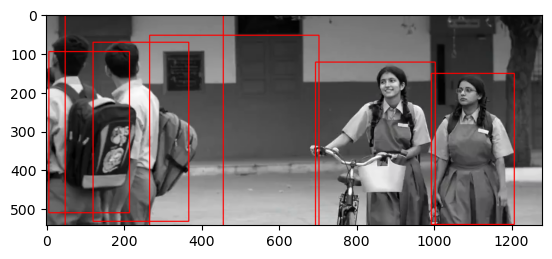

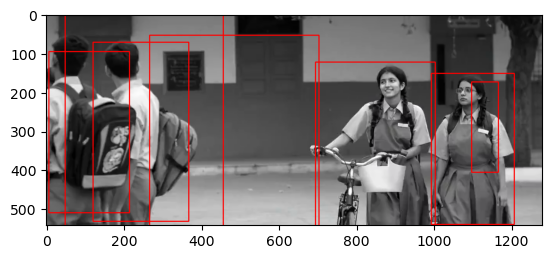

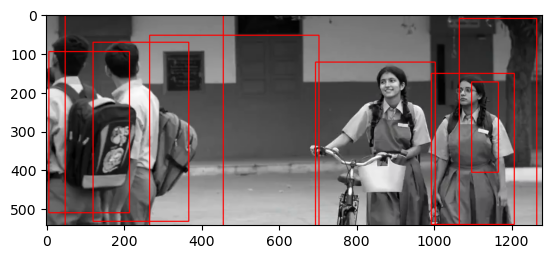

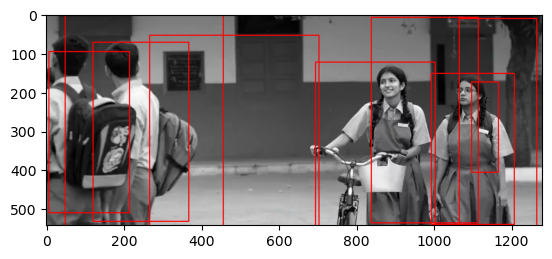

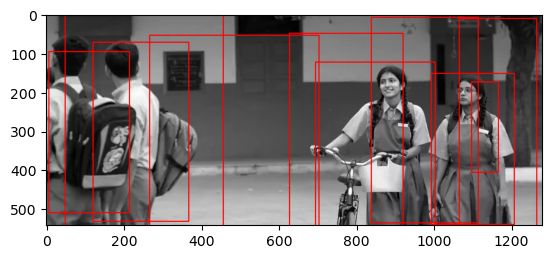

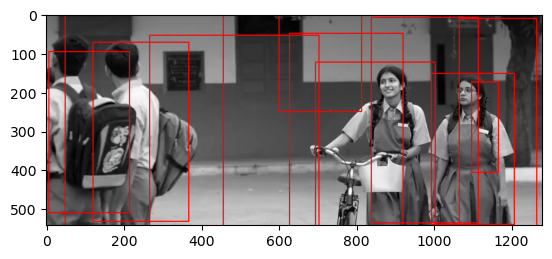

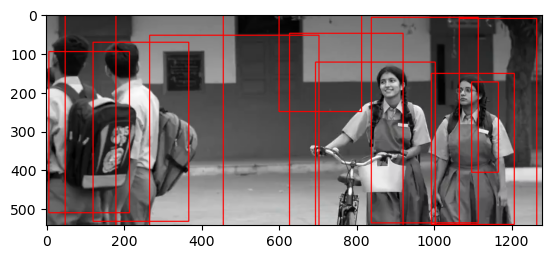

In [515]:

for i in maxed_out[0][1]:
    box=i
    x,y,w,h=box[0],box[1],box[2],box[3]
    temp=cv2.rectangle(det_obj[0][0],(x,y),(x+w,y+h),(255,0,0),2)
    plt.imshow(temp)
    plt.show()
# cv2.rectangle(det_obj[0][0],)
# det_obj[0][2]